## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Öğrenme Eğrileri (Learning Curves)


🎯 Bu egzersiz, bir modelin performansını **bias** ve **variance** açısından teşhis etmek; ayrıca **underfitting** ve **overfitting** durumlarını tespit edip düzeltmek için Learning Curves kullanmayı kapsar.

❓ [NBA.csv](https://d32aokrjazspmn.cloudfront.net/materials/NBA.csv) dataset’ini bu notebook’a bir pandas dataframe olarak yükleyin ve ilk 5 satırını görüntüleyin.

In [2]:
import pandas as pd

df = pd.read_csv("data/NBA.csv")
df.head()

,season,poss,mp,do_ratio,pacing,win_rating
0,1987,4847,2409,-1.546275,-0.599918,1.643091
1,2017,5582,2708,0.996587,0.531888,10.808427
2,2016,4976,2407,0.242598,0.127976,3.054773
3,2021,1178,585,-1.343806,-1.201034,0.230004
4,1988,4534,2056,-1.813990,-0.128997,0.905614


ℹ️ Dataset’in detaylı açıklamasını challenge README dosyasında bulabilirsiniz. Challenge boyunca buna mutlaka referans verin.

## 1. Cross-Validation

❓ Oynanan dakika sayısına (`mp`) göre oyuncunun win rating’ini tahmin etmeyi amaçlayan bir Linear Regression modeli için cross-validation çalıştırın.  
Skorların ortalamasını `cv_score` değişkenine kaydedin.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

X = df[["mp"]]
y = df["win_rating"]

cv_results = cross_validate(LinearRegression(), X, y, cv=5, scoring="r2")
cv_score = cv_results["test_score"].mean()
cv_score

0.5567301800068911

### ☑️ Kodunu Test Et

In [4]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'cv_score',
    score = cv_score
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /Users/gizemtotkanli/code/totkanligizem/03-Decision-Science/02-Linear-Regression/learning-curves/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_cv_score.py::TestCvScore::test_cv_score PASSED                      [100%]

============================== 1 passed in 0.05s ===============================


💯 You can commit your code:

git add tests/cv_score.pickle

git commit -m 'Completed cv_score step'

git push origin master



## 2. Öğrenme Eğrileri (Learning Curves)

Learning curves, model performansını daha derinlemesine teşhis etmek için kullanılır.
 
❓ Modelin learning curves’lerini plot edin ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html)). 

Training size’lar için **100** satırdan başlamalı ve dataset’in %80’i training’de kullanılana kadar (**3200**) her seferinde **100** artırmalısınız. Bu şekilde toplamda **32** dilim elde etmelisiniz. [np.arange](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) işinize yarayabilir!

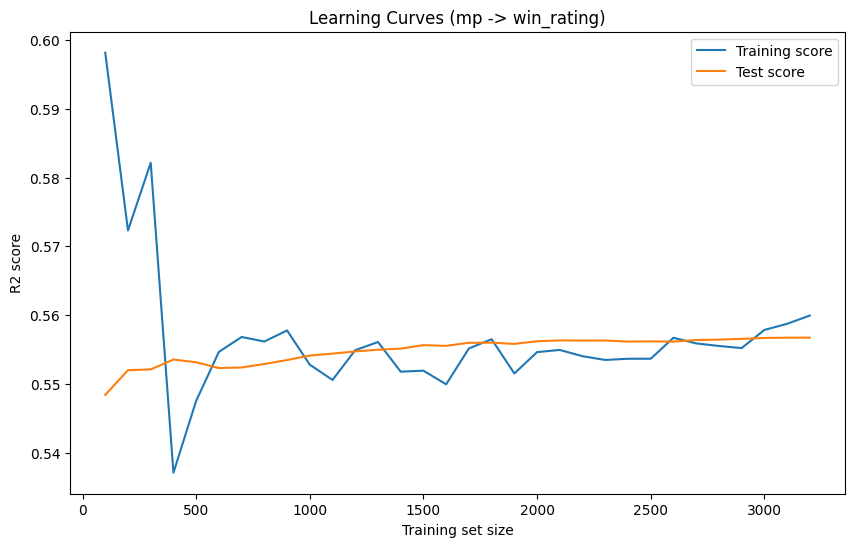

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes = np.arange(100, 3201, 100)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=LinearRegression(),
    X=X,
    y=y,
    train_sizes=train_sizes,
    cv=5,
    scoring="r2"
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Test score")
plt.xlabel("Training set size")
plt.ylabel("R2 score")
plt.title("Learning Curves (mp -> win_rating)")
plt.legend()
plt.show()

❓ Öğrenme eğrilerini nasıl yorumlarsınız?

<details>
<summary> ℹ️ Yorumumuzu görmek için bu hücreyi açın </summary>   
    
<br/>
    
**Underfitting** gözlemliyoruz.

👉 Eğrilerin düşük bir skor seviyesinde birbirine yakınsaması gerekirdi (ölçeğe dikkat edin: bazen birbirlerinden uzakmış gibi görünebilirler ama skorları aslında çok yakındır! Daha net görmek için <code>plt.ylim()</code> değerini değiştirmeyi deneyebilirsiniz)
- Training score, training set boyutu arttıkça belirgin şekilde düşmüş
- Testing score ise, dataset’in %80’i training için kullanılsa bile, neredeyse hiç artmamış — %1’den az!

👉 Underfitting’e yol açan iki tipik neden vardır:
- Model, verideki örüntüleri öğrenmek için **çok basit**
- Modelin, oyuncu win rating’ini daha iyi tahmin edebilmesi için **daha fazla feature**’a ihtiyacı var
    
</details>


## 3. Özellikler Ekleme (Adding Features)

Şimdiye kadar gördüğümüz kadarıyla model performansı optimal görünmüyor. Daha fazla özellik ekleyerek bunu düzeltmeyi deneyebiliriz - NBA fantezi ligi arkadaşımızın önerdiği özellikleri deneyelim!

❓ Oyuncuların galibiyet oranını tahmin etmek için oluşturulan modeli aşağıdakilerle çapraz doğrulayın:
- Oynanan dakika sayısı (`mp`)
- Topa sahip olma sayısı (`poss`)
- Savunma/hücum oranı (`do_ratio`)
- Tempo

Çapraz doğrulanan yeni puanı `score_added_features` adlı bir değişken altında kaydedin.

In [6]:
X_full = df[["mp", "poss", "do_ratio", "pacing"]]
cv_results_full = cross_validate(LinearRegression(), X_full, y, cv=5, scoring="r2")
score_added_features = cv_results_full["test_score"].mean()
score_added_features

0.6321354129549308

ℹ️ Modelin performansının artmış olması gerekirdi! Feature eklemek, modele verideki örüntüleri öğrenmesi ve modellemesi için ek bilgi sağlar.

## 4. Öğrenme Eğrileri 2 (Learning Curves 2)

❓ Yeni modelin performansını daha ayrıntılı olarak değerlendirmek için öğrenme eğrilerini çizin (eğrileri daha belirgin hale getirmek için [plt.ylim()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html) ile oynayabilirsiniz).

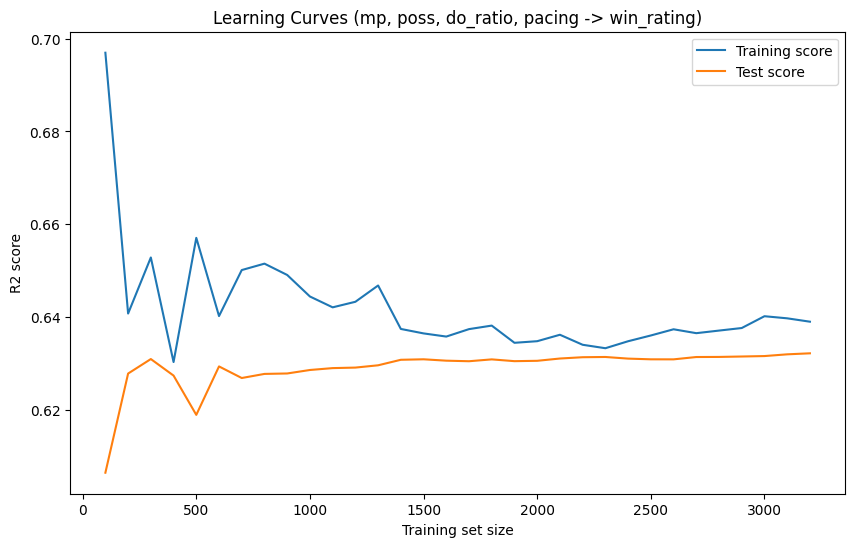

In [7]:
train_sizes = np.arange(100, 3201, 100)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=LinearRegression(),
    X=X_full,
    y=y,
    train_sizes=train_sizes,
    cv=5,
    scoring="r2"
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Test score")
plt.xlabel("Training set size")
plt.ylabel("R2 score")
plt.title("Learning Curves (mp, poss, do_ratio, pacing -> win_rating)")
plt.legend()
plt.show()

❓ Learning curves’ü nasıl yorumlarsınız?

<details>
<summary> ℹ️ Yorumumuzu görmek için bu hücreyi açın </summary>   
    
<br/>
    
Bir iyileşme var, ancak hâlâ bir miktar **underfitting** olduğu görülüyor.

👉 Eğrilerin birbirine yakınsamış olması gerekirdi, fakat training score hâlâ testing score’daki artışa kıyasla çok daha fazla düşüyor.

👉 Daha fazla feature eklemek bir miktar yardımcı oldu, ancak underfitting problemini tamamen çözmedi. Bu nedenle diğer tipik duruma bakabiliriz:
- Model, verideki örüntüleri öğrenmek için **çok basit**
    
</details>

## 5.Polinom Özellikleriyle Doğrusal Model Uyumunu İyileştirme (Improving Linear Model Fit with Polynomial Features)

Şu ana kadar dataset’imizdeki feature’larla yapabileceğimizin en iyisini yaptık, ancak hâlâ bazı **underfitting** belirtileri görüyoruz.

Bu durum, win rating ile oyuncu feature’ları arasındaki ilişki için yalnızca lineer kombinasyonlara dayanmanın modelimizi **fazla basit** kılıyor olabileceğini düşündürüyor — bunu biraz **feature engineering** ile düzeltmeyi deneyebiliriz. 🛠️

🔍 Oyuncu win rating’ini açıklama / tahmin etme gücümüzün büyük bir kısmı, oynanan dakika sayısı (`mp`) feature’ından geliyor. Gelin bu feature’a daha yakından bakalım.

👇 Bu iki sütun arasındaki ilişkiyi gösteren bir scatterplot çizin. seaborn veya matplotlib kullanmakta özgürsünüz.

<Axes: xlabel='mp', ylabel='win_rating'>

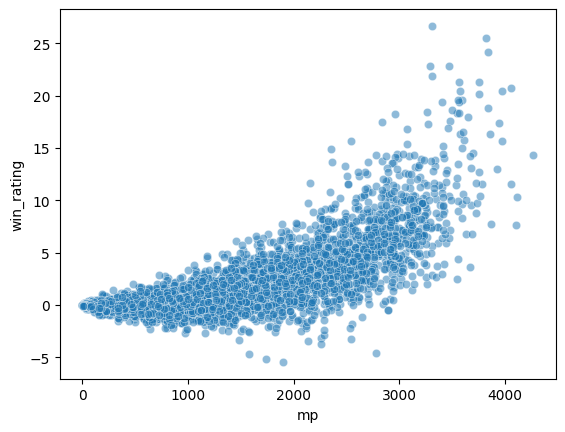

In [8]:
sns.scatterplot(data=df, x='mp', y='win_rating', alpha=0.5)

🎯 `mp` ve `win_rating` ile **holdout** kullanarak bir `LinearRegression` modeli eğitelim.

👇 Öğrenilen regresyon çizgisini aynı grafiğe çizerek verilere ne kadar uyduğunu görelim. Unutmayın, eğitilmiş bir doğrusal modelin katsayılarını `coef_` ve `intercept_` ile çıkarabilirsiniz.

Model R2: 0.5441185829799919


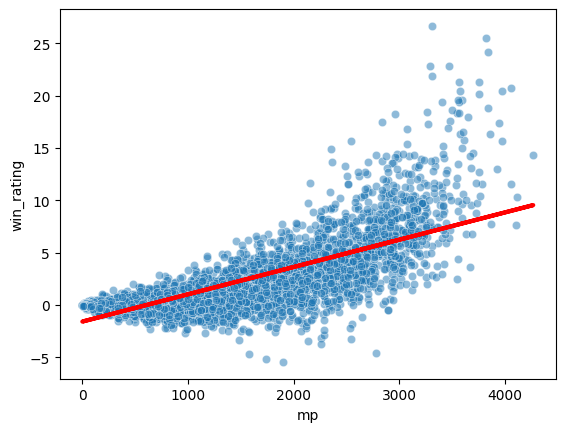

In [9]:
# Modelin eğitilmesi
model = LinearRegression()

X = df[['mp']]
y = df['win_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model.fit(X_train, y_train)

# modelin puanlanması
lin_reg_score = model.score(X_test, y_test)
print("Model R2:", lin_reg_score)

# katsayıları ve regresyon fonksiyonunu çıkarma
regression = model.coef_[0] * df['mp'] + model.intercept_

# verileri ve öğrenilen regresyon fonksiyonunu çizme
sns.scatterplot(data=df, x='mp', y='win_rating', alpha=0.5)
plt.plot(df['mp'], regression, color='red', linewidth=3)

❓ Modelimizin yetersiz kalmasına neden olabilecek faktörleri görebiliyor musunuz?


<details>
<summary> ℹ️ Yorumumuzu görmek için bu hücreyi açın </summary>   
    
<br/>
    
Linear Regression modelinin öğrendiği düz bir doğruyu, *eğrisel (curvilinear)* şekilde dağılım gösteren bir veriye uydurmaya çalıştığımız görülüyor.
    
</details>



Modeli geliştirmeyi, [**Polynomial Features**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) ekleyerek deneyebiliriz.

Polynomial feature’lar, mevcut feature’ların belirli bir dereceye kadar olan çarpımlarından oluşur. Örneğin iki feature’ımız varsa — `a` ve `b` — ve degree-2 polynomial feature’lar eklersek, şu feature set’i elde ederiz: [`a`, `b`, `a`$^2$, `a` $*$ `b`, `b`$^2$].

sklearn’in `PolynomialFeatures` sınıfının oluşturduğu üsler sayesinde, oyuncuların win rating’leri ile oynadıkları dakika sayısı arasında gözlemlediğimiz gibi **eğrisel (curvilinear)** ilişkileri daha yakından temsil edebilen bir model eğitebiliriz.

Hadi deneyelim! 🚀

👇 Feature set’imiz `X`’i degree-2 polynomial features ile güncelleyelim.  
Verinin nasıl dönüştürüleceğini görmek için sklearn dokümantasyonundaki [örneği](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#Examples:~:text=linear_model/plot_polynomial_interpolation.py-,Examples,-%3E%3E%3E) inceleyin — aşağıdaki ilk örnek bizden 😉

In [10]:
polynomial_features = PolynomialFeatures(degree=2, include_bias=False) # 1'lerden oluşan bir sütun eklemek istemiyoruz
X_poly = polynomial_features.fit_transform(X)

X_poly = pd.DataFrame(X_poly) # daha kolay işlemek için tekrar DataFrame'e dönüştürmek
X_poly.head()

,0,1
0,2409.0,5803281.0
1,2708.0,7333264.0
2,2407.0,5793649.0
3,585.0,342225.0
4,2056.0,4227136.0


☝️ Dönüştürme işlemi nedeniyle sütun adlarının kaybolduğunu fark edin — isterseniz bunları güncelleyebilirsiniz ya da sadece ilk sütunun orijinal `mp`, yeni sütunun ise `mp`$^2$ olduğunu aklınızda tutun.

🎯 `degree=2` polinom özelliği eklemenin, modelin oynanan dakika sayısı ile oyuncunun galibiyet oranı arasındaki ilişkiyi daha iyi temsil etmesine yardımcı olup olmadığını kontrol edelim.

👇 Aşağıdaki hücreyi çalıştırarak, derece-2 polinom özellikleri, yani `mp` ve `mp`$^2$ üzerinde eğitilmiş bir model tarafından oluşturulan yeni regresyon çizgisini görün. 

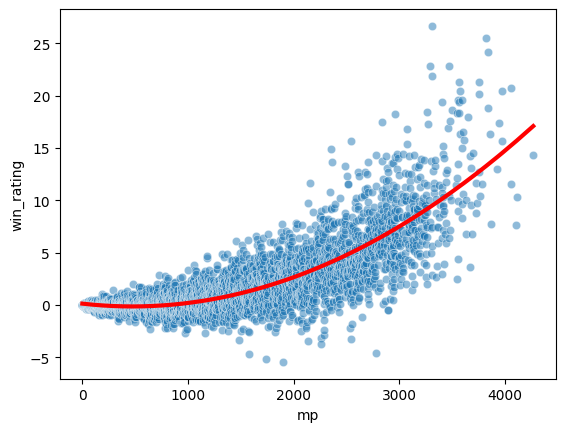

In [11]:
## Burada, verileri sıralıyoruz, böylece dağılım grafiğimize son
## çizgimizi çizdiğimizde düzgün görünsün.
## Egzersizin ilerleyen kısımlarında bunu yapmanız gerekmeyecek!

sorted_df = df.sort_values('mp')

X_sorted = sorted_df[['mp']]
y_sorted = sorted_df['win_rating']

#polinom özelliklerimizi oluşturuyoruz
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_sorted)

#fit model
model.fit(X_poly, y_sorted)

predictions = model.predict(X_poly)

#orijinal veriler üzerinde grafik tahminleri (plot)
sns.scatterplot(x=X_sorted['mp'], y=y_sorted, alpha=0.5)
plt.plot(X_sorted['mp'], predictions, linewidth=3, color='r')

💡 Yeni regresyon eğrisi verimize daha iyi uyuyor gibi görünüyor — doğru yoldayız!

## 6. En uygun derece sayısını seçmek (Picking the best number of degrees)

🔢 Şimdi **tam feature set’imize** geri dönelim — `['mp', 'poss', 'do_ratio', 'pacing']`

`mp` üzerinde Polynomial Features kullanmanın modeli iyileştirdiğini gördük, peki dataset’in geri kalanı için durum nasıl? 🤔

❓ Tüm dataset için `degree=2` polynomial features ile eğitilmiş bir modeli cross-validate edin. Skor, önceki modellere kıyasla nasıl değişiyor?

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

X = df[['mp', 'poss', 'do_ratio', 'pacing']]
y = df['win_rating']

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly2 = poly2.fit_transform(X)

scores_deg2 = cross_val_score(LinearRegression(), X_poly2, y, cv=5, scoring='r2')
score_degree_2 = scores_deg2.mean()

score_degree_2

0.8697420123126577

Model skorunun ciddi şekilde iyileşmiş olması gerekir! Peki `degree=2`’nin en iyisi olduğunu nereden biliyoruz; 3, 5 ya da 10 neden olmasın? Modele daha fazla serbestlik derecesi vermek modeli her zaman daha iyi yapar, değil mi? 🤔

❓ Polynomial feature’ların `degree` değerini **1**’den **10**’a kadar değiştirerek cross-validation yapın. Tüm skorları kaydedin ve en iyi sonucu belirlemek için skorları ilgili degree değerleriyle birlikte plot edin.

🕰️ **NOT:** Tüm döngünün çalışması biraz zaman alacaktır; çünkü daha yüksek polynomial degree değerleri üstel olarak daha fazla feature oluşturur.

❓ Çalışırken şunu düşünün: `degree=10` ile dataset’inizde toplam kaç feature olacak?

</br>

<details>
<summary> 🆘 Cevap için buraya tıklayın </summary>   

Her bir feature için, farklı üslerde 10 yeni feature oluşturursunuz — bu zaten **44** feature eder. Ardından feature’ların tüm olası çarpım kombinasyonları eklenir ve sonuçta yaklaşık **1000** feature ortaya çıkar.
    
</details>

Best degree: 2
Best CV R2: 0.8697420123126577


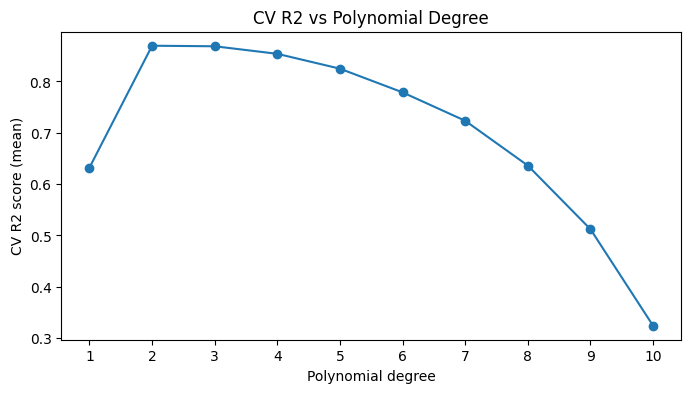

In [13]:
import matplotlib.pyplot as plt

degrees = list(range(1, 11))
mean_scores = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_poly = poly.fit_transform(X)

    scores = cross_val_score(LinearRegression(), X_poly, y, cv=5, scoring='r2')
    mean_scores.append(scores.mean())

best_degree = degrees[int(np.argmax(mean_scores))]
best_score = float(np.max(mean_scores))

print("Best degree:", best_degree)
print("Best CV R2:", best_score)

plt.figure(figsize=(8, 4))
plt.plot(degrees, mean_scores, marker='o')
plt.xlabel("Polynomial degree")
plt.ylabel("CV R2 score (mean)")
plt.title("CV R2 vs Polynomial Degree")
plt.xticks(degrees)
plt.show()

❓ NBA oyuncularının win rating’ini tahmin etmek için hangi polynomial feature derecesi en uygunudur?

<br/>

<details>
<summary> ℹ️ Cevabınızı doğrulamak için buraya tıklayın </summary>   
    
☝️ `degree=2` değerinin en iyi skoru verdiğini görmelisiniz — geri kalan feature’ları da ekledikten sonra skor **0.87** seviyesine kadar çıkıyor!
    
</details>

😱 Peki, `degree=5`'ten sonra ne olur? *Daha da fazla* bilgiyle model sonuçları düşmeye başlar mı?

👇 Sorunu belirlemek için `degree=5` polinom özelliklerine sahip bir modelin öğrenme eğrilerini çizin.

In [ ]:
# X'imizi polinom özelliklerini içerecek şekilde dönüştürün
poly_features = PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly_features.fit_transform(X)

# `learning_curve`, r2 skoru kullanarak eğitim puanlarını, eğitim boyutlarını ve doğrulama puanlarını alın
train_sizes, train_scores, test_scores = learning_curve(
    estimator = LinearRegression(),
    X = X_poly,
    y = y,
    train_sizes = train_sizes,
    cv = 5
)

# Çapraz doğrulanan (cross-validated) eğitim puanlarının ve test puanlarının ortalamasını alın 
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Öğrenme eğrilerini çizin!
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.ylim(0,1)
plt.legend();

❓ Bu learning curves’ü nasıl yorumlarsınız?


<details>
<summary> ℹ️ Yorumumuzu görmek için bu hücreyi açın </summary>   
    
<br/>
    
Belirgin bir **overfitting** görüyoruz!
    
👉 Eğriler birbirine yakınsamıyor; model, training verisini aşırı öğreniyor. Training score (`~0.9`), testing score’dan (`~0.7`) belirgin şekilde daha yüksek kalıyor.
    
👉 Degree-5 polynomial feature’lar eklendiğinde, modelin dikkat ettiği “noise” miktarı fazla görünüyor ve öğrenilen katsayılar artık gerçeği temsil etmiyor.
    
</details>

## 7. Eğitim Setinin Boyutunu Küçültme (Reducing Training Set Size)

🎯 Artık elde edebileceğimiz en iyi model skorunu bulduğumuza göre, hesaplama kaynaklarından tasarruf etmek için modeli daha az veriyle eğitip eğitemeyeceğimize bakalım.

👇 En iyi modelimizin learning curves’lerini plot edelim — tüm feature’lar ile `degree=2` polynomial.

In [ ]:
# eğitim boyutu dilimlerini oluşturun
train_sizes = np.linspace(100, 3200, 32, dtype='int')

X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)

# `learning_curve`, r2 skoru kullanarak eğitim puanlarını, eğitim boyutlarını ve doğrulama puanlarını alın
train_sizes, train_scores, test_scores = learning_curve(
    estimator = LinearRegression(),
    X = X_poly,
    y = y,
    train_sizes = train_sizes,
    cv = 5
)

# Çapraz doğrulanan (cross-validated) eğitim puanlarının ve test puanlarının ortalamasını alın 
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Öğrenme eğrilerini çizin!
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, label = 'training score')
plt.plot(train_sizes, test_scores_mean, label = 'test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend();

❓Yeni öğrenme eğrilerine bakarak, modelin veri kümesinin kalıplarını öğrenmesi için kaç tane eğitim örneği yeterlidir?

👇 Cevabı bulduktan sonra aşağıdaki hücreyi çalıştırarak kontrol edin.

In [ ]:
# Öğrenme eğrilerini çizme
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, label = 'training score')
plt.plot(train_sizes, test_scores_mean, label = 'test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)

# Eğitim ve test puanlarının farkının <%1 olduğu bir çizgi çizme
plt.axvline(1400, linestyle='--', c='black')
plt.annotate('Past this line:\ntrain_score - test_score <= 0.01', xy=(1450, 0.7))


# Bu çizgideki ve maksimum eğitim verilerindeki (verilerin %80'i) test puanlarını karşılaştırmaplt.scatter(train_sizes[14], test_scores_mean[14], c='orange', s=50)
plt.annotate(
    f"R2: {round(test_scores_mean[14], 2)}",
    xy=(train_sizes[14] + 50, test_scores_mean[14] - 0.03),
    fontsize=12, c='orange'
)

plt.scatter(train_sizes[31], test_scores_mean[31], c='orange', s=50)
plt.annotate(
    f"R2: {round(test_scores_mean[31],2)}",
    xy=(train_sizes[31] - 200, test_scores_mean[31] - 0.03),
    fontsize=12, c='orange'
)


plt.legend();

ℹ️ Veri arttıkça training süresi de uzar. Bazı durumlarda çok büyük dataset’lerle çalışırsınız. Bu gibi durumlarda learning curves, training size’ı (ve dolayısıyla training süresini!) azaltırken yüksek performanslı bir modeli korumak arasında doğru dengeyi bulmanıza yardımcı olabilir.

`train_size=1500` noktasındaki skor, neredeyse tüm dataset kullanıldığında elde edilen skorla aynıdır! Öte yandan, hesaplama maliyetini ciddi şekilde azaltmış olurdunuz — 1TB’lık bir dataset’in %60’ını tasarruf ettiğinizi hayal edin!

## 8. Model Tahminlerini Karşılaştırma (Comparing Model Predictions)

👇 Modellerimizin $R^2$ skorlarının nasıl değiştiğini gördük, şimdi de **modellerin ne kadar doğru tahmin yaptığını** inceleyelim.

❓ **Tüm dataset** üzerinde eğitilmiş iki model için MSE (*Mean Squared Error* — `predictions - targets` farklarının karelerinin ortalaması) hesaplayın:

1. Tüm feature’lar ile eğitilmiş bir model — `mp`, `poss`, `pacing` ve oyuncunun defense/offense oranı
2. `degree=2` polynomial features ile eğitilmiş bir model

❓ Ortaya çıkan MSE değerlerini sırasıyla `reg_score` ve `poly_score` adlı değişkenlere kaydedin

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = df[['mp', 'poss', 'do_ratio', 'pacing']]
y = df['win_rating']

# 1) Düz Linear Regression (tüm feature’lar)
reg_model = LinearRegression()
reg_model.fit(X, y)
reg_preds = reg_model.predict(X)
reg_score = mean_squared_error(y, reg_preds)

# 2) Degree=2 Polynomial Features + Linear Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(X_poly, y)
poly_preds = poly_model.predict(X_poly)
poly_score = mean_squared_error(y, poly_preds)

reg_score, poly_score

❓ İki puanı karşılaştırdığınızda ne gözlemliyorsunuz?

### ☑️ Kodunu Test Et

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'prediction',
    feat_3_score = reg_score,
    poly_3_score = poly_score
)

result.write()
print(result.check())

# 🏁 Başardınız! Artık kodunuzu commit ve push etme zamanı

Sadece learning curves üzerinde (bol bol) pratik yapmakla kalmadınız, aynı zamanda sklearn’in `PolynomialFeatures` aracıyla ilk *preprocessing transformer*’ınızı da kullandınız — ki bu, bir sonraki dersin ana konusu olacak 🙌